# AI to Make your Boring Bank Statements Useful

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
pd.options.mode.chained_assignment = None

In [44]:
# read in the data
origin = pd.read_csv("data.csv", sep = ";", error_bad_lines = False, encoding = "latin1")


## 1. Supervised Learning Model Idea

In order to achieve our goal, I think we need two seperate models. The first is a simple categorization model that simply takes in purchase information from the bank and categorizes it into one of the expense categories. The second one would be a predictive model that takes in past purchases and send interventions before a future purchases happen.

For the first model, our outcome variable is the category, and the features we can use could include dates, hours of the day, amount, credit limit infomation, but most vitally, we need purchase infomation and invoice from the seller. If we could have the invoice on each purchase, then buidling a NLP model using recurrent neural network would be the most appropriate. The steps are:

1) Download word embeddings that are already available from online. Word embeddings are assoications that would connect words like "delta" to "airlines" or "museum" to "tourism". These already developed embeddings are trained on billions of text phrases, so they are very accurate and convinient to use.

2) Divide our data into training set, development set and test set. The split depends on the size of data. With the set of data given here, maybe a 60/20/20 split is appropriate, but if our dataset is much bigger, then we can have a much higher percentage to the training set, such as maybe a 90/5/5 split.

3) Represent the invoice as vectors with word embeddings we downloaded and feed them into our neural network. The output would be a category at the end of the network. We will use back-proporgation and gradient descent to update our parameters in the neural network.

4) Run the model to see the training error. These models should in theory do quite well, so we should keep improving the model until we achieve very small training error. Ways to improve include buidling deeper networks with more layers, or replacing the cells with LSTMs (Long short-term memory) to better capture long range dependencies.

5) Run the model on the dev set to get the dev error. If the dev error is much higher than the training error, then the model overfitted. We could add some regularizaiton or dropout techniques. We should train the model multiple times until the dev error is small as well.

6) Finally, it's important to visualize the instances where we categorized wrong. If there is a pattern, then we can go back to the model and try to fix that specific category.

7) The last step is to run the model on the test set to get an unbiased estimate of model error.

For the second model, we want to predict user's purchase before it happens. In this case, the outcome variable is still category, while the features would be past purchases. We can directly feed observations into a model, or we can engineer some features to feed into the model. The steps are:

1) Feature engineering. We can create some features from the past observations, such as how many groceries runs in the past week, which day of the week does restarant bill incur and so on to try to predict the category of the next purchase.

2) Model training. We can split the data in a way that's similar to model 1. The model here could be a neural network sequance model. However, we could also try other models such as trees, random forests or models that take into account time, such as the ARMA model (Autoregressive–moving-average model). 

3) Run the model to see the training error. If the error is big, then we should try and see if the error is general or concentrated on specific categories. If the error is general with no pattern, then we should try to use another model. If the error is occuring on only some categories, then we should first go back to the first step and try to develop better features.

4) Run the model on the dev set to get the dev error. If the dev error is much higher than the training error, then the model overfitted. Each model should have its own sets of regularization tools we can use. 

5) Once the training error and the dev error are both small, we can run the final model on the test set to get an unbiased estimate of model error.

5) Finally, we need to set triggers that would send messages to the users. For example, if our model predicts that the user is going to eat out today, but his credit is running low, then a relevant message would be sent.

6) It's also important to collect user feedback once in a while and update the model and the triggers accordingly.

## 2. Challenges in buidling the model

1) In building the first model, the obvious challenge here is that we don't have the invoice or purchase information. It would be very hard to build an accurate categorization model without any text or invoice. We cannot categorize purchases simply based on the amount, or date etc.

2) In building the second model, one challenge might be that for some users the time frame is too short to identify any trend. Some users only have the bank statement for a few months, which would not be enough to build a predictive model.

3) The regional data in the dataset is too broad. Where the purchase took place could have very important implications for our model, but right now in the dataset, it only has purchase city, which is not super helpful.

## 3. Pre-processing

#### 1) The ID column seems long and are in scientific notation. It might be better to just use dummies to represent them for all our analysis, and we can match them in the end. 

In [26]:
# create dic to map id
id_dic = {id: new_id for new_id, id in enumerate(origin["id"].unique())}
# create new column
origin["newid"] = origin["id"].apply(lambda s: id_dic[s])

#### 2) We need to translate the columns and the categories to English.

In [27]:
# translate col names
col_name = {"id": "old_id", "celular": "phone", "safra_abertura": "branch", 
            "cidade": "city", "estado": "state", "idade": "age", "sexo": "gender", "limite_total" : "total_limit",
           "limite_disp" : "available_limit", "data" :"date", " valor " : "amount", "grupo_estabelecimento" : "category_spanish", 
            "cidade_estabelecimento":  "purchase_city", "pais_estabelecimento" : "purchase country", "newid": "new_id"}
origin.rename(col_name, axis = 1, inplace = True)

# translate categories
cate_dic = {"SERVI\x82O" :"service", "FARMACIAS" : "drugstore", "M.O.T.O." : "online",  "ARTIGOS ELETRO" : "electronics",
"VAREJO" : "convenience store" ,"LOJA DE DEPART" : "department store", "VESTUARIO" : "clothing", "HOSP E CLINICA" : "health", 
            "SEM RAMO" : "other expenses", "SUPERMERCADOS" : "supermarket",  "MAT CONSTRUCAO" : "construction material", 
            "POSTO DE GAS" : "gas", "RESTAURANTE" : "restaurant", "MOVEIS E DECOR": "furniture", "CIA AEREAS" : "airlines", 
            "JOALHERIA" : "jewelry",  "TRANS FINANC" : "financial transfers", "AGENCIA DE TUR" : "tourism", "HOTEIS" : "hotels",
            'AUTO PE\x82AS': "auto", 'INEXISTENTE': "unclear", 'ALUG DE CARROS': "auto"
}
origin["category_spanish"] = origin["category_spanish"].str.strip()

#create new colomn
origin["category"] = origin["category_spanish"].apply(lambda x: cate_dic[x])

#### 3) We need to change the commas in the amount to a dot to indicate decimal.

In [28]:
# replace comma by dot, and convert to int type
origin["amount"] = origin["amount"].str.replace(",", ":")
origin["amount"] = origin["amount"].str.replace(".", "")
origin["amount"] = origin["amount"].str.replace(":", ".")

origin["amount"] = pd.to_numeric(origin["amount"], errors = "coerce")

#### 4) We need to convert the date into a datetime object so we can extract useful infomation.

In [29]:
# create datetime object
origin["datetime"] = origin["date"].apply(lambda x: datetime.strptime(x, "%d/%m/%y"))

# create year, month, date
origin["year"] = origin["datetime"].apply(lambda x: x.year)
origin["month"] = origin["datetime"].apply(lambda x: x.month)
origin["day"] = origin["datetime"].apply(lambda x: x.day)

# sort data by person and date
origin.sort_values(by = ["new_id", "datetime"], inplace = True)


#### 5）Finally, it is important to categorize the purchases into essential vs. non.essential, this would help us trementously in understanding behaviors and send important info. to our financial sponsors.

In [30]:
# create the function
def essential(data):
    if data in ["service", "convenience store", "supermarket", "drugstore", "gas", 
                "health ", "clothing", "construction material", "auto", "furniture", "financial transfers"]:
        return 1
    else:
        return 0

# create "essential" column
origin["essential"] = origin["category"].apply(essential)

## 4. Comsumer Behavior Analysis- Profile I: Those who should better manage expenses

In this task, I choose to focus on the specific group who should better manage their expenses, and compare their consumer trend before Covid and after Covid. To perform this analysis, we first have to identify who those people are. I will use three different metrics to identify them. In this identification stage, we will only use data before Covid to identify them.

### Identification

#### 1) Frequency of usage. People who use their credit cards much more often than others should be identified as needing to manage expenses better.

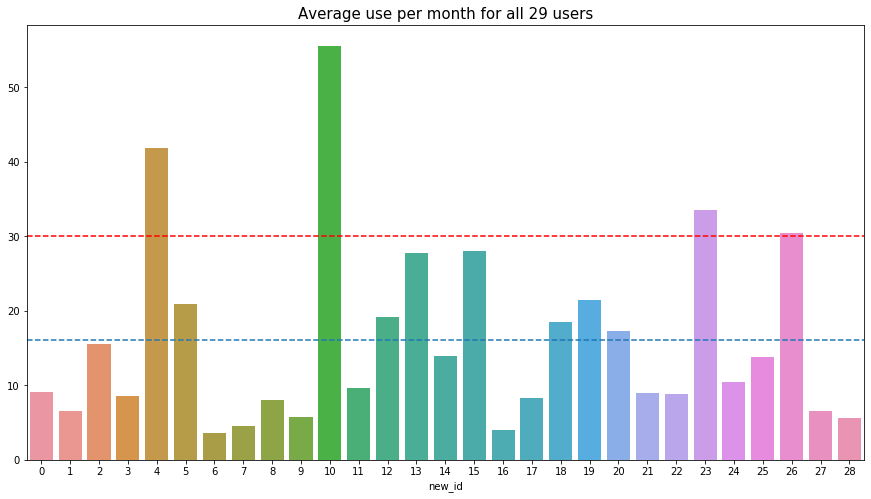

In [31]:
# filter data to pre_covid
analysis4 = origin[origin["datetime"] < "2020-03-18"]

# calculate total uses per user
total_use = analysis4.groupby("new_id").size()

# calculate total unique month per user
analysis4["year_month"] = analysis4["datetime"].apply(lambda x: x.strftime("%y-%m"))
unique_month = (analysis4.groupby("new_id")["year_month"].unique())
num = unique_month.apply(lambda x: len(x))

#get frequency and plot
frequency = (total_use/num).sort_values(ascending = False)
plt.figure(figsize = (15,8))
ax1 = sns.barplot(x = frequency.index, y = frequency)
ax1.set_title("Average use per month for all 29 users", fontsize = 15)
ax1.axhline(frequency.mean(), ls = "--")
ax1.axhline(30, color = "red", ls = "--")

# compile high usage users
user_dic  = {"high_freq" :[4, 10, 23]}

From here, we can clearly see that user 4, 10 and 23 are much higher than average and more than 30 times per month, so they would be classified as those who need better money management.


#### 2) Percentage of non-essential purchases to total usage. People who spend much more on non-essential goods should be identified as needing to manage expenses better.

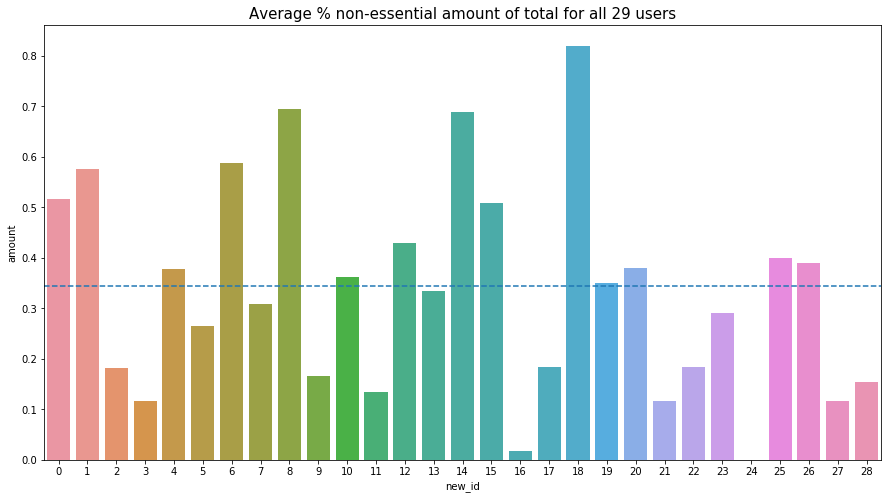

In [32]:
# generate total usage and non-essential useage
total = analysis4.groupby("new_id")["amount"].sum()
non_essential = analysis4[analysis4["essential"] == 0].groupby("new_id")["amount"].sum()

# calculate percentage and plot
percent_to_total = non_essential/total
plt.figure(figsize = (15,8))
ax1 = sns.barplot(x = percent_to_total.index, y = percent_to_total)
ax1.set_title("Average % non-essential amount of total for all 29 users", fontsize =15)
ax1.axhline(percent_to_total.mean(), ls = "--")

#append high percentage users to dic
user_dic["non_essential"] = [1,6, 8, 14,18]


Users 1, 6, 8, 14, 18 all spend more than 60% of money on non-essential goods, so they would also be classified as those who need better money management.

#### 3) People who have a lot of one-time purchases that are too much given their credit level should manage their finances better. (We don't count the times where the amount exceeds the available limit, since that's another category.

In [33]:
# get the percentage
analysis4["amount_percent"] = analysis4["amount"]/analysis4["available_limit"]

# filter out high percentage and count by user
filtered = analysis4[(analysis4["amount_percent"] > 0.8) & (analysis4["amount_percent"] <1)]

# count by user
print(filtered.groupby("new_id").size())

# add to list
user_dic["high_onetime"] = [5,9 ,10]


new_id
4     1
5     4
9     3
10    8
11    1
13    1
14    1
20    1
22    1
dtype: int64


We can see that users 5, 9 and 10 have made more than 1 purchases than exceeds 80% of their available limit. We add them to the list.

### So we finalized our 10 users in total for analysis: 1, 4, 5, 6, 8, 9, 10, 14,  18, 23

### Behavior Analysis

#### In this analysis, since we are choosing on metric over one period of time, I decided to understand the % essential vs. %non-essential expenses and their respective quantities, and compare their pre-COVID level to the COVID level for the users we identified. Since there are 10 of them, and they are identified by seperate metrics, I will analyze them seperately.


In [34]:
def select_data(key):
    # select high_freq users and appropriate data
    mask = origin["new_id"].apply(lambda x: x in user_dic[key])
    temp = origin[mask]
    df = temp[temp["datetime"] > "2020-01-01"]

    # create the df for analysis
    toplot1 = df.groupby(["month", "essential"])["amount"].sum().reset_index()
    toplot1["amount"] = toplot1["amount"]/len(user_dic[key])
    non_essential = df[df["essential"] == 0].groupby("month")["amount"].sum()
    total = df.groupby("month")["amount"].sum()
    non_percent = non_essential/total
    return toplot1, non_percent



#### Absolute Amount comparison between 3 types of users who need better money management

(0, 3000)

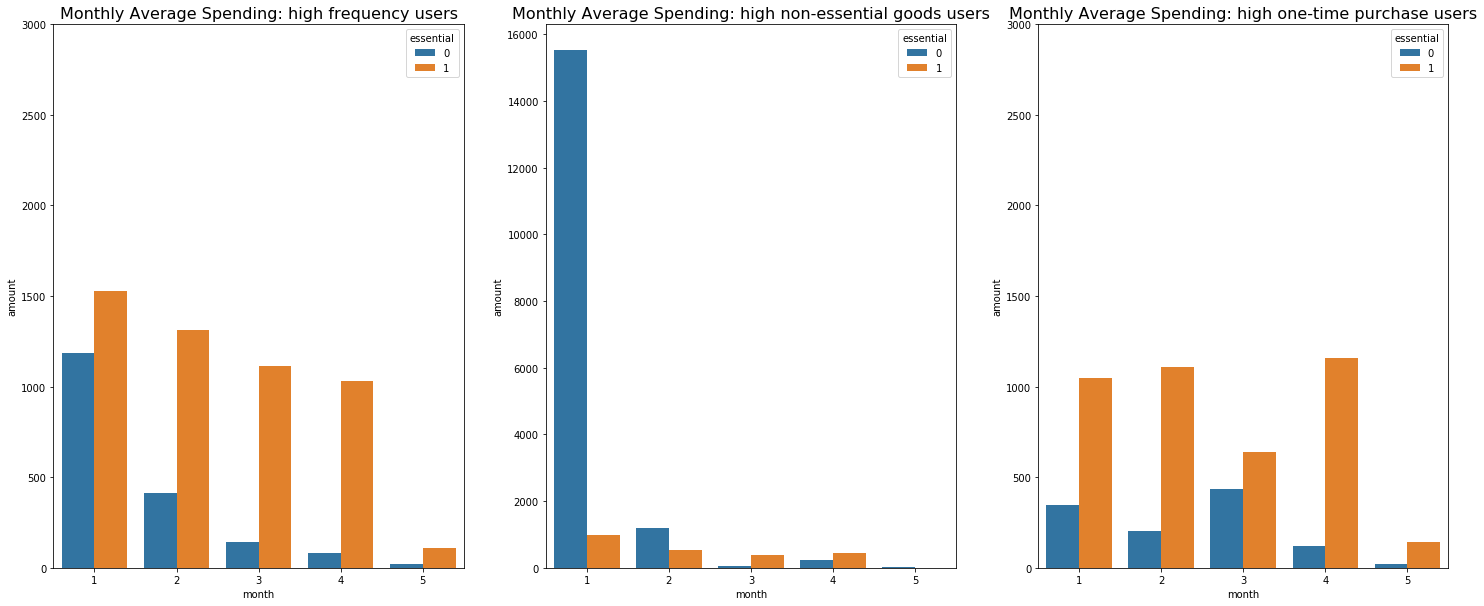

In [35]:
high_frequency, high_frequency_percent = select_data("high_freq")
high_nonessential, high_nonessential_percent = select_data("non_essential")
high_onetime, high_onetime_percent = select_data("high_onetime")

#plot
fig = plt.figure(figsize = (25,10))
ax1 = fig.add_subplot(1,3,1)
ax1 = sns.barplot(x = high_frequency["month"], y = high_frequency["amount"], hue =high_frequency["essential"])
ax1.set_title("Monthly Average Spending: high frequency users", fontsize = 16)
ax1.set_ylim(0,3000)
ax2 = fig.add_subplot(1,3,2)
ax2 = sns.barplot(x = high_nonessential["month"], y = high_nonessential["amount"], hue =high_nonessential["essential"])
ax2.set_title("Monthly Average Spending: high non-essential goods users",fontsize = 16)
ax3 = fig.add_subplot(1,3,3)
ax3 = sns.barplot(x = high_onetime["month"], y = high_onetime["amount"], hue =high_onetime["essential"])
ax3.set_title("Monthly Average Spending: high one-time purchase users", fontsize = 16)
ax3.set_ylim(0,3000)



#### Percentage Compasion between 3 types of users who need better money management

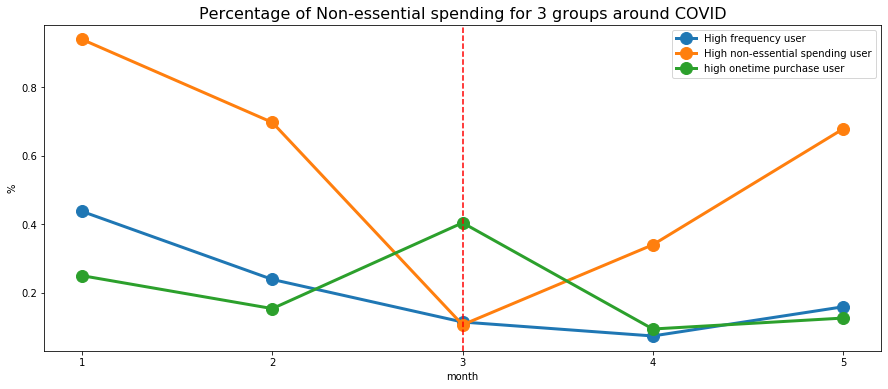

In [36]:
plt.figure(figsize = (15,6))
p1 = plt.plot( high_frequency_percent.index, high_frequency_percent, label = "High frequency user", linewidth=3, marker='o', markersize=12 )
p2 = plt.plot( high_nonessential_percent.index,  high_nonessential_percent, label = "High non-essential spending user", linewidth=3, marker='o', markersize=12 )
p3 = plt.plot(high_onetime_percent.index, high_onetime_percent, label = "high onetime purchase user", linewidth=3, marker='o', markersize=12 )
plt.axvline(3, color = "red", ls = "--")
plt.title("Percentage of Non-essential spending for 3 groups around COVID", fontsize = 16)
plt.ylabel("%")
plt.xlabel("month")
plt.xticks([1,2,3,4,5])
plt.legend()



#### Main takeaways:
1) For people who spend very frequently and people who have high non-essential spending, they spent a lot on non_essentials in Jan., and this drops down dramatically in Feb. We can probably understand it as holiday season travelling and shopping. For the people with high non-essential spending, this amount is a shocking ~15,500 Br dollor per person per month, and it drops to below 2,000 in Feb.

2) During Covid in March and April, there is a slight drop in essential spending, but a much bigger drop in non-essential spending. This does not hold for the group with high onetime spending. Thier non-essential spending acutually increased in March, although this sample size is small.

3) In terms of %Non-essential spending of total spending, the high frequency group has it under 50% through this period, and it drops gradually during COVID. The high non-essential group started at 90% and sharply dropped to 10% in March, before going up to 35% in April and 65% in May. The high one-time purchase group has it around 30-40%. 

## 5. Banco Pan Top 3 Features

### 1) For Banco Pan thinking about loaning money to individuals, one of the most important thing is to identify irresponsible customers. Something interesting to look at is how often users spent more than their availible credit across different age group, and whether its on essential goods.

Text(0.5, 1.0, 'Average occurances of over-credit-limit purchases per person by age group')

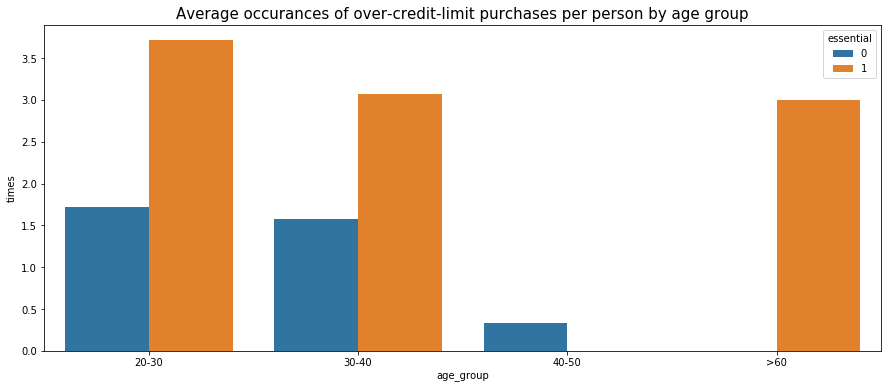

In [37]:
# divide by age group
def age_divide(data):
    if data < 20:
        return "<20"
    elif 20 <= data < 30:
        return "20-30"
    elif 30 <= data < 40:
        return "30-40"
    elif 40 <= data < 50:
        return "40-50"
    elif 40 <= data < 50:
        return "40-50"
    else:
        return ">60"

origin["age_group"] = origin["age"].apply(lambda x: age_divide(x))

# create data for plot
overspent = origin[origin["amount"] > origin["available_limit"]]
temp = overspent.groupby(["age_group", "essential"]).size().reset_index()
plot2 = temp.rename(columns = {0: "times"})
plot2["times"] = plot2["times"]/[7, 7, 14, 14, 6, 2]

#plot
plt.figure(figsize = (15,6))
ax1 = sns.barplot(x = plot2["age_group"], y = plot2["times"], hue =plot2["essential"])
ax1.set_title("Average occurances of over-credit-limit purchases per person by age group", fontsize = 15)



    

The 20-30 age group has the most over credit limit purchases and the 40-50 age group has the least. For 20-30 and 30-40 age groups, 2/3 of the over credit limit purchases are on essential goods. For the >60 age group, all occurances are essential. The bank could potentially encourage them to expand their credit limit.

### 2) Banco Pan should also track the area where user spending is going, especially how the trend is changing pre-covid and during covid, so it could better support its users.

Text(0.5, 1.0, 'Spending by Category During Covid')

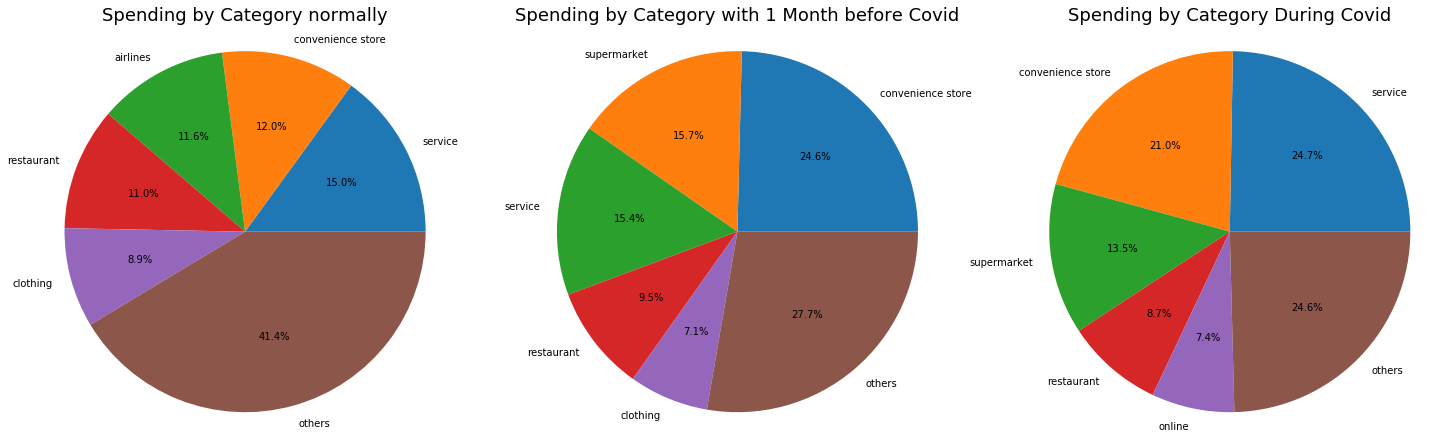

In [38]:
# categorize timeline
no_covid = origin[origin["datetime"] < "2020-2-18"]
pre_covid = origin[ ("2020-2-18" < origin["datetime"]) & (origin["datetime"] < "2020-3-18")]
during_covid = origin[origin["datetime"] > "2020-3-18"]

# get percentage
def graph_cate(df):    
    temp = df.groupby("category")["amount"].sum()
    df_percent = (temp / df["amount"].sum()).sort_values(ascending = False)
    df_percent_filtered = df_percent.head()
    df_percent_final = pd.concat([df_percent_filtered, pd.DataFrame([1 - df_percent_filtered.sum()], index = ["others"])]).squeeze()
    graph = plt.pie(df_percent_final, labels = df_percent_final.index, autopct='%1.1f%%', radius = 1.1) 
    return graph

#plot
fig = plt.figure(figsize = (25,15))
ax1 = fig.add_subplot(1,3,1)
graph_cate(no_covid)
ax1.set_title("Spending by Category normally", fontsize = 18)
ax2 = fig.add_subplot(1,3,2)
graph_cate(pre_covid)
ax2.set_title("Spending by Category with 1 Month before Covid", fontsize = 18)
ax3 = fig.add_subplot(1,3,3)
graph_cate(during_covid)
ax3.set_title("Spending by Category During Covid", fontsize = 18)



We can see that without Covid, the top 5 categories include service, convenience store, airlines, restaurant and clothing, but airlines dropped out the month before Covid, and clothing is replaced by online shopping during Covid. There's a much higher percentage spent on conveience stores and supermarkets right before Covid and during Covid, which makes sense as people prepare for the pandemic. These two categories should continue to grow in the near future. Interstingly, spending on restaurant only went down by 2.3%, indicating that people are still ordering takeouts regularly.

### 3) For Banco Pan, it's also important to understand how spending behavior differs by users with different credit limit.

In [39]:
# categorizing users based on credit
temp = origin.groupby("new_id")["total_limit"].mean().sort_values()
credit_dic = {"low": temp[temp <3000].index, "medium low": temp[(temp <5000) & (temp >3000)].index,
              "medium high": temp[(temp <10000) & (temp >5000)].index, "high": temp[temp >10000].index}

# create df &plot function
def graph_limit(key):
    origin["year_month"] = origin["datetime"].apply(lambda x: x.strftime("%y-%m"))
    mask = origin["new_id"].apply(lambda x: x in credit_dic[key])
    df = origin[mask]
    toplot2 = df.groupby("year_month")["amount"].sum().reset_index()
    toplot2["amount"] = toplot2["amount"]/len(credit_dic[key])
    return plt.plot(toplot2["year_month"], toplot2["amount"], label = "{} credit limit".format(key), linewidth=3)
    


Text(0.5, 1.0, 'Average Spending Per Person Per Month')

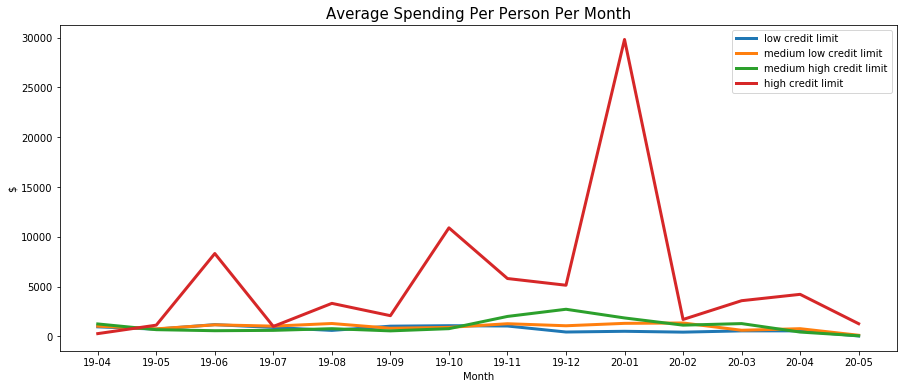

In [40]:
#plotting 
plt.figure(figsize = (15,6))
graph_limit("low")
graph_limit("medium low")
graph_limit("medium high")
graph_limit("high")
plt.legend()
plt.xlabel("Month")
plt.ylabel("$")
plt.title("Average Spending Per Person Per Month", fontsize = 15)

We can see that people with a higher credit limit generally spend more. Although this difference is quite small for the low credit group, medium low credit group and the medium high credit group. The high credit group (>10,000 Br$) spends much more than the other groups and also fluctuates more from month to month. 